## Frank Wolfe and Randomized Frank Wolfe for the Lasso problem
### Synthetic dataset and real dataset (E2006-TF-IDF)

In [1]:
import numpy as np
import pylab as plt
import random
import time
from scipy import sparse

### Creation of synthetic dataset

In [2]:
def generate_dataset(n, d, nz, eps):
    """
    Input:
    n   : # of rows
    d   : # of columns
    nz  : % of non zero coefficients
    eps : % of noise
    """
    np.random.seed(0)
    # Gaussian matrix
    A = np.random.normal(0,1,(n,d))
    
    # Number of elements different form 0
    non_zero = int(d*nz)
    
    # Choice of a random set of values in an interval of length d
    subset = np.random.choice(np.arange(d), non_zero, replace = False)
    
    # Vector of a certain percentage (nz) of nonzero coefficients and values in {-1,1}
    # 0*2-1 = -1, 1*2-1 = 1.
    x_star= np.zeros(d)
    for i in range(non_zero):
        x_star[subset[i]] = np.random.randint(0,2)*2 -1

    # Target value
    noise = eps*np.random.rand(n)
    b = A.dot(x_star) + noise
    
    return (A, b, x_star)

In [3]:
def e(i, d):
    ei = np.zeros(d)
    ei[i] = 1
    return ei

In [4]:
n = 200
d = 500
nz = 0.1
eps = 0.1
A, b, x_star= generate_dataset(n, d, nz, eps)

### Frank Wolfe

In [5]:
def FW(A, b, alpha, T, tol):
    """
    Input:
    A        : data matrix
    b        : target values
    alpha    : L1-ball radius
    T        : number of performed iterations
    tol      : tolerance
    """
    
    gap_values = []
    support = []
    time_ = []
    time_lmo = []
    
    # starting value 
    x_t = alpha * e(1,d)
    Atb = A.T.dot(b)
    
    for it in range(1, T + 1):
        # starting time
        t0 = time.time()
        
        # gradient
        Ax = A.dot(x_t)
        gradient = (A.T.dot(Ax) - Atb)
        
        # LMO
        time_1 = time.time()
        oracle_index = np.argmax(np.abs(gradient))
        s_ti = alpha * np.sign(-gradient[oracle_index])
        time_2 = time.time()
        time_lmo.append(time_2-time_1)
        
        # direction
        d_t = -x_t.copy()
        d_t[oracle_index] += s_ti
        
        # exact line search for the stepsize
        q_t = A.dot(d_t)
        step_size = q_t.dot(b - Ax)/ (q_t.dot(q_t))
        
        # dual gap
        gap = -d_t.T.dot(gradient)

        # stopping rule
        if gap <= tol:
            print("FW algorithm stopped due to gap <= tol:", gap)
            break
            
        gap_values.append(float(gap))
        
        # update the vector x_t
        x_t = x_t + float(step_size)*d_t
        
        t1 = time.time()
        time_.append(t1-t0)
        
        # support
        non_zero = np.count_nonzero(x_t)
        support.append(non_zero)
        
    return  gap_values, support, time_, time_lmo

### Randomized Frank Wolfe with non-continuos slicing

In [6]:
def RFW_ncs(A, b, alpha, T, tol, eta):
    """
    Input:
    A        : data matrix
    b        : target values
    alpha    : L1-ball radius
    T        : number of performed iterations
    tol      : tolerance
    eta      : sampling parameter
    
    """
    
    np.random.seed(13)
    gap_values=[]
    support = []
    time_ = []
    time_lmo = []
    
    # starting value
    x_t = alpha * e(1,d)
    Atb = A.T.dot(b)
    
    for it in range(1, T+1):
        # starting time
        t0 = time.time()
        
        # gradient
        Ax = A.dot(x_t)
        gradient = (A.T.dot(Ax) - Atb)
        gradient_old = gradient.copy()
        
        # sampling some elements from the gradient
        At = random.sample(range(d), d - int(d*eta))
        gradient[At] = 0
        
        # randomized LMO
        time_1 = time.time()
        oracle_index = np.argmax(np.abs(gradient))
        s_ti = alpha * np.sign(-gradient[oracle_index])
        time_2 = time.time()
        time_lmo.append(time_2-time_1)
        
        # randomized direction
        d_t = -x_t.copy()
        d_t[oracle_index] += s_ti
        
        # exact line search for the stepsize
        q_t = A.dot(d_t)
        step_size = q_t.dot(b - Ax)/ (q_t.dot(q_t))
        
        # deterministic LMO
        oracle_index_det = np.argmax(np.abs(gradient_old))
        s_ti_det = alpha * np.sign(-gradient_old[oracle_index_det])
        
        # deterministic direction
        d_t_det= -x_t.copy()
        d_t_det[oracle_index_det] +=  s_ti_det
        
        # dual gap
        gap = -d_t_det.T.dot(gradient_old)
        
        # stopping rule
        if gap <= tol:
            print("FW algorithm stopped due to gap <= tol:", gap)
            break  
        
        gap_values.append(float(gap))
        
        # update the vector x_t
        x_t = x_t + float(step_size) * d_t
        
        t1 = time.time()
        time_.append(t1 - t0)
        
        # support
        non_zero = np.count_nonzero(x_t) 
        support.append(non_zero)
        
    return gap_values, support, time_, time_lmo

### Randomized Frank Wolfe with continuous slicing

In [7]:
def RFW_cs(A, b, alpha, T, tol, eta):
    """
    Input:
    A        : data matrix
    b        : target values
    alpha    : L1-ball radius
    T        : number of performed iterations
    tol      : tolerance
    eta      : sampling parameter
    
    """
    
    np.random.seed(13)
    gap_values=[]
    support = []
    time_ = []
    nbr = []
    time_lmo = []
    
    # starting value
    x_t = alpha * e(1,d)
    Atb = A.T.dot(b)
        
    for it in range(1, T+1):    
        # starting time
        t0 = time.time()
        
        # gradient
        Ax = A.dot(x_t)
        gradient = (A.T.dot(Ax) - Atb)
        gradient_old = gradient.copy()
        
        # continuous slicing of the gradient
        initial_point = np.random.randint(0,d)
        subset = (initial_point, min(initial_point + int(d*eta), d)) 
        gradient = gradient_old[subset[0]:subset[1]]
        
        # randomized LMO
        time_1 = time.time()
        oracle_index = np.argmax(np.abs(gradient))
        oracle_index = oracle_index + initial_point
        s_ti = alpha * np.sign(-gradient_old[oracle_index])
        time_2 = time.time()
        time_lmo.append(time_2-time_1)
        
        # randomized direction
        d_t = -x_t.copy()
        d_t[oracle_index] += s_ti
        
        #exact line search for the stepsize
        q_t = A.dot(d_t)
        step_size = q_t.dot(b - Ax)/ (q_t.dot(q_t))
        
        # deterministic LMO
        oracle_index_det = np.argmax(np.abs(gradient_old))
        s_ti_det = alpha * np.sign(-gradient_old[oracle_index_det])
        
        # deterministic direction
        d_t_det= -x_t.copy()
        d_t_det[oracle_index_det] +=  s_ti_det
        
        # dual gap
        gap = -d_t_det.T.dot(gradient_old)
        
        # stopping rule
        if gap <= tol:
            print("FW algorithm stopped due to gap <= tol:", gap)
            break  
        
        gap_values.append(float(gap))
        
        # update the vector x_t
        x_t = x_t + float(step_size) * d_t
       
        t1 = time.time()
        time_.append(t1 - t0)
        
        # Nbr coefficients of gradient
        number_of_coefficient = subset[1] - subset[0]
        nbr.append(number_of_coefficient)
        
        # support
        non_zero = np.count_nonzero(x_t) 
        support.append(non_zero)
        
    return gap_values, nbr , support, time_, time_lmo

### Experiments

In [8]:
# Parameters initialization
alpha = 50
T = np.power(10,5)
tol = 1e-3
eta = 0.05

In [9]:
# Frank wolfe
gap_values_det, support_det, time_det, time_lmo_det = FW(A, b, alpha, T, tol)

In [10]:
# Randomized Frank Wolfe with non continuous slicing
gap_values_random_ncs, support_random_ncs, time_random_ncs, time_lmo_ncs = RFW_ncs(A, b, alpha, T, tol, eta)

In [11]:
# Randomized Frank Wolfe with continuous slicing
gap_values_random_cs, nbr, support_random_cs, time_random_cs, time_lmo_cs = RFW_cs(A, b, alpha, T, tol, eta)

### Graphical representation

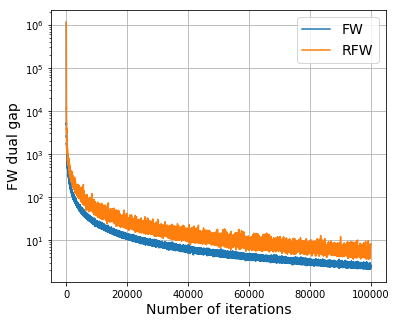

In [12]:
# gaps comparison
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_yscale("log")
ax.plot(gap_values_det)
ax.plot(gap_values_random_ncs)
plt.xlabel("Number of iterations", fontsize = 14)
plt.ylabel("FW dual gap", fontsize = 14)
plt.legend(["FW", "RFW"], fontsize = 14)
plt.grid()
#plt.ylim([1,10**3])
plt.show()

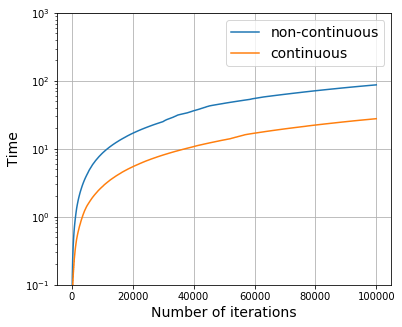

In [13]:
# time comparison for the different ways of sampling from the gradient
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_yscale("log")
ax.plot(np.cumsum(time_random_ncs))
ax.plot(np.cumsum(time_random_cs))
plt.xlabel("Number of iterations", fontsize = 14)
plt.ylabel("Time", fontsize = 14)
plt.legend(["non-continuous", "continuous"], fontsize = 14)
plt.grid()
plt.ylim([10**-1,10**3])
plt.show()

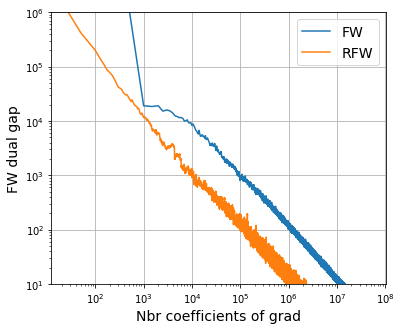

In [14]:
# progress of the gap versus the cumulative number of computed coefficients of gradient per call to LMO
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
plt.xlabel('Nbr coefficients of grad', fontsize = 14)
plt.ylabel('FW dual gap', fontsize = 14)
plt.loglog(np.cumsum(np.ones(T)*d),gap_values_det)
#1. non-contiunous slicing
plt.loglog(np.cumsum(np.ones(T)*d*eta),gap_values_random_ncs)
#2. continuous slicing
#plt.loglog(np.cumsum(nbr),gap_values_random_cs)
plt.ylim([10,10**6])
plt.legend(['FW','RFW'], fontsize = 14)
plt.grid()
plt.show()

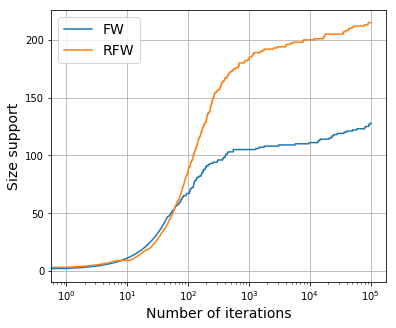

In [15]:
# size of support of the of iterate versus number of iterations
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_xscale("log")
plt.plot(support_det)
plt.plot(support_random_ncs)
plt.xlabel("Number of iterations", fontsize = 14)
plt.ylabel("Size support", fontsize = 14)
plt.legend(["FW", "RFW"], fontsize = 14)
plt.grid()
plt.show()

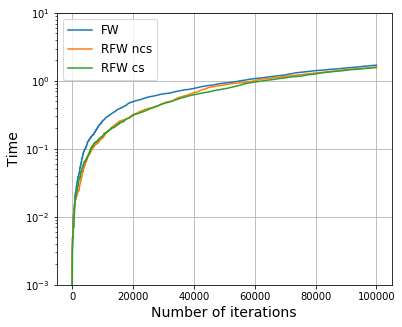

In [16]:
# comparison of the LMO time for the three algorithms
fig = plt.figure(figsize =(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_yscale("log")
plt.plot(np.cumsum(time_lmo_det))
plt.plot(np.cumsum(time_lmo_ncs))
plt.plot(np.cumsum(time_lmo_cs))
plt.xlabel("Number of iterations",fontsize = 14)
plt.ylabel("Time",fontsize = 14)
plt.legend(["FW", "RFW ncs","RFW cs"],fontsize = 12)
plt.grid()
plt.ylim([10**-3,10])
plt.show()

# Dataset E2006-tf-idf

In [17]:
A = sparse.load_npz("C://Users//Francesca//Desktop//Progetto_optim//real_matrix.npz")
b = np.load("C://Users//Francesca//Desktop//Progetto_optim//target.npy")
n, d = A.shape 

### Experiments

In [36]:
# Parameters initialization
T = 1000
alpha = 1000
tol = 1e-3
eta = 0.06

In [37]:
# Frank wolfe
gap_values_det, support_det, time_det, time_lmo_det = FW(A, b, alpha, T, tol)

In [38]:
# Randomized Frank Wolfe with non-continuous slicing
gap_values_random_ncs, support_random_ncs, time_random_ncs, time_lmo_ncs = RFW_ncs(A, b, alpha, T, tol, eta)

In [39]:
# Randomized Frank Wolfe with continuous slicing
gap_values_random_cs, nbr, support_random_cs, time_random_cs, time_lmo_cs = RFW_cs(A, b, alpha, T, tol, eta)

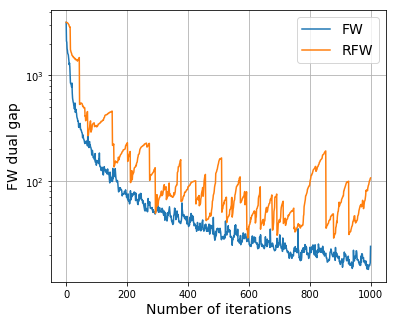

In [40]:
# gaps comparison
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_yscale("log")
ax.plot(gap_values_det)
ax.plot(gap_values_random_ncs)
plt.xlabel("Number of iterations", fontsize = 14)
plt.ylabel("FW dual gap", fontsize = 14)
plt.legend(["FW", "RFW"], fontsize = 14)
plt.grid()
plt.show()

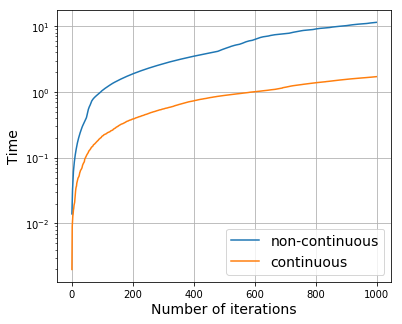

In [41]:
# time comparison for the different ways of sampling from the gradient
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_yscale("log")
ax.plot(np.cumsum(time_random_ncs))
ax.plot(np.cumsum(time_random_cs))
plt.xlabel("Number of iterations", fontsize = 14)
plt.ylabel("Time", fontsize = 14)
plt.legend(["non-continuous", "continuous"], fontsize = 14)
plt.grid()
plt.show()

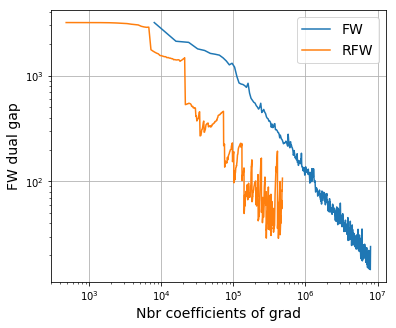

In [42]:
# progress of the gap versus the cumulative number of computed coefficients of gradient per call to LMO
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
plt.loglog(np.cumsum(np.ones(T)*d),gap_values_det)
# non-continuous slicing
plt.loglog(np.cumsum(np.ones(T)*d*eta),gap_values_random_ncs)
# continuous slicing
#plt.loglog(np.cumsum(nbr),gap_values_random_ncs)
plt.xlabel('Nbr coefficients of grad', fontsize = 14)
plt.ylabel('FW dual gap', fontsize = 14)
plt.legend(['FW','RFW'], fontsize = 14)
plt.grid()
plt.show()

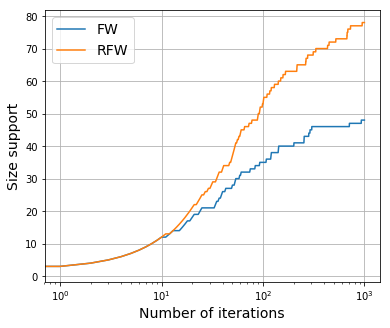

In [43]:
# size of support of the iterate versus number of iterations
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_xscale("log")
plt.plot(support_det)
plt.plot(support_random_ncs)
plt.xlabel("Number of iterations", fontsize = 14)
plt.ylabel("Size support", fontsize = 14)
plt.legend(["FW", "RFW"], fontsize = 14)
plt.grid()
plt.show()

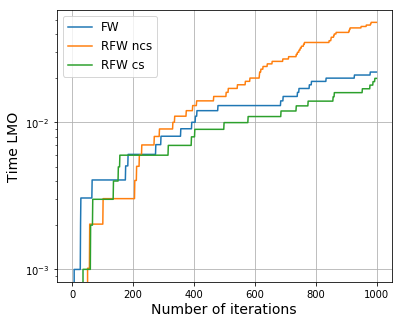

In [44]:
# comparison of the LMO time for the three algorithms
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_yscale("log")
plt.plot(np.cumsum(time_lmo_det))
plt.plot(np.cumsum(time_lmo_ncs))
plt.plot(np.cumsum(time_lmo_cs))
plt.xlabel("Number of iterations", fontsize = 14)
plt.ylabel("Time LMO", fontsize = 14)
plt.legend(["FW", "RFW ncs","RFW cs"], fontsize = 12)
plt.grid()
#plt.ylim([10**-2,1])
plt.show()